# Portfolio analysis
This notebook introduces the concept of portfolio-level analyses. In this notebook, the results of the asset-level analysis are translated into firm-level results which are subsequently translated into portfolio-level results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from prisk.utils import extract_firms, link_basins
from prisk.portfolio import Portfolio

import matplotlib.font_manager as font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
flood_protection = 100
insured = False
insurer_capital = 2e9
simulations = 1000
country = "India"
random_seed = 0

In [3]:
# All files for the analysis are stored on the S3 buckets instead of the random samples (these are too large and take a long time to load)
power = pd.read_excel("https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/power.xlsx")
hybas_basins = "https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/hybas_as_lev06_v1c.shp"
basin_outlet_file = "https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/HA_L6_outlets_India_constrained.csv"

The files containing the randomly generated samples can be generated using the notebooks found in the Exploratory analysis folder. Alternatively, they can be downloaded from the link in the package README.md file.

In [4]:
gaussian_random_numbers = pd.read_parquet("../Data/gaussian_random_numbers_cooccurrence_india.parquet.gzip")
t_random_numbers = pd.read_parquet("../Data/t_random_numbers_cooccurrence_india.parquet.gzip")
vine_random_numbers = pd.read_parquet("../Data/vine_random_numbers_cooccurrence_india.parquet.gzip")
uniform_random_numbers = pd.read_parquet("../Data/uniform_random_numbers_india.parquet.gzip")
complete_dependent_random_numbers = pd.read_parquet("../Data/complete_dependent_random_numbers_india.parquet.gzip")

##### Extracting Agents
The P-RISK model is based on asset-level analyses that are subsequently translated into firm- and portfolio-level impacts. To extract the firms from the Global Energy Monitor database, we use a utility function. If this approach is applied on a different dataset, then the extract_firms function needs to be replaced. We assume flood protection levels (consistent with other literature).

We limit the analysis to a single country.

In [5]:
india = power[power["Country"] == country].copy().reset_index(drop=True).drop(columns=[2])
india.loc[:, "flood_protection"] = india[flood_protection]
firms = extract_firms(india)

##### Portfolio construction
The portfolio consists of the firms linked to the assets located in Thailand. We assume an equal weighted portfolio:

In [6]:
portfolio = Portfolio("Thailand power assets")
nav = 1
for firm in firms:
    portfolio.add_position(firm, nav/(len(firms)*firm.npv))                    

In [7]:
india, basins = link_basins(india, hybas_basins, basin_outlet_file, visualize=False);
base_asset = "Obra Thermal Power Station"
base_basin = india[india["Plant / Project name"] == base_asset]["HYBAS_ID"].values[0]

/Users/rubenkerkhofs/Documents/Oxford/PRISK/.env/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: HTTP response code on https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/hybas_as_lev06_v1c.CPG: 403
  return ogr_read(


### Basin-Level Independence

In [36]:
basin_correlations = gaussian_random_numbers.corr()[base_basin]
t_correlations = t_random_numbers.corr()[base_basin]
vine_correlations = vine_random_numbers.corr()[base_basin]

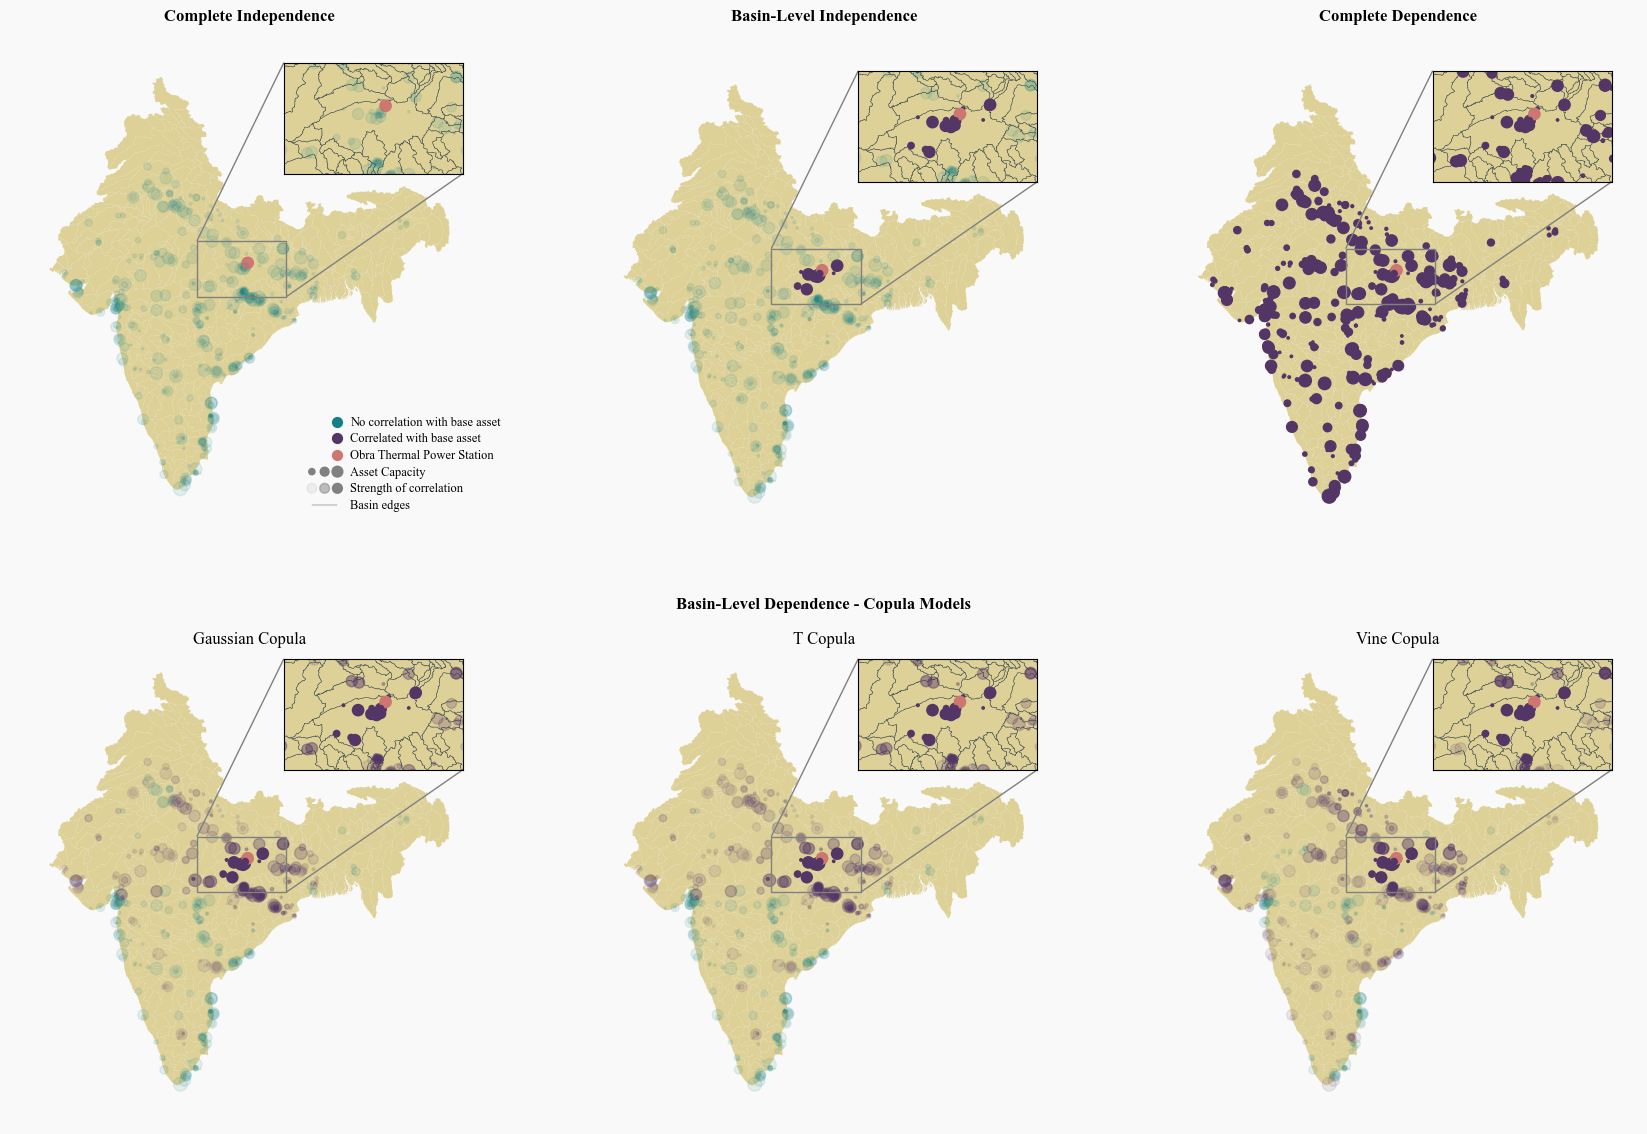

In [70]:
import numpy as np

font_man = font_manager.FontProperties(family='Times New Roman',
                                   style='normal', size=12)
font = {"size": 12, "name": "times new roman"}


fig, ax = plt.subplots(2, 3, figsize=(21, 14))
fig.set_facecolor("#f9f9f9")
for axes in ax:
    for axis in axes:
        axis.set_facecolor("#f9f9f9")

titles = ["", "", "", "Gaussian Copula", "T Copula", "Vine Copula"]
for i, axis in enumerate(ax.flatten()):
    axis.set_title(titles[i], fontdict=font)
# Set a title for each row
def create_subtitle(fig, grid, title):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=12, fontfamily='times new roman')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

grid = plt.GridSpec(2, 3)
create_subtitle(fig, grid[0, 0], 'Complete Independence')
create_subtitle(fig, grid[0, 1], 'Basin-Level Independence')
create_subtitle(fig, grid[0, 2], 'Complete Dependence')
create_subtitle(fig, grid[1, ::], 'Basin-Level Dependence - Copula Models')


font = {"size": 9, "name": "times new roman"}

########################
# COMPLETE INDEPENDENCE
########################
axis = ax[0][0]
def determine_color(row):
    if row["Plant / Project name"] == base_asset:
        return "#CD7672"
    else:
        return "#138086"
base_asset = "Obra Thermal Power Station"
india.loc[:, "correlation"] = india["Plant / Project name"].apply(lambda x: 1 if x == base_asset else 0.1)
india.loc[:, "color"] = india.apply(lambda x: determine_color(x), axis=1)

divider = make_axes_locatable(axis)
basins.plot(ax=axis, color="#DDD197")
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.get_xaxis().set_ticks([])
axis.get_yaxis().set_ticks([])

# Add geographic points
axis.scatter(india.Longitude, india.Latitude, 
            c=india.color, s=india["Capacity (MW)"]/10, 
            alpha=india.correlation)

axis.scatter(x=90, y=13, s=50, color="#138086")
axis.text(x=91, y=12.75, s="No correlation with base asset", fontdict=font)

axis.scatter(x=90, y=11.8, s=50, color="#543666")
axis.text(x=91, y=11.55, s="Correlated with base asset", fontdict=font)

axis.scatter(x=90, y=10.6, s=50, color="#CD7672")
axis.text(x=91, y=10.35, s=base_asset, fontdict=font)

axis.scatter(x=[88, 89, 90], y=[9.4, 9.4, 9.4], s=[20, 40, 60], color="grey")
axis.text(x=91, y=9.15, s="Asset Capacity", fontdict=font)

axis.scatter(x=[88, 89, 90], y=[8.2, 8.2, 8.2], s=50, color="grey", alpha=[0.1, 0.5, 1])
axis.text(x=91, y=7.95, s="Strength of correlation", fontdict=font)

axis.plot([88, 89, 90], [7, 7, 7], linewidth=0.3, color="#2a3b42")
axis.text(x=91, y=6.75, s="Basin edges", fontdict=font)


# Add zoomed in plot
ind_india = india.copy() # necessary
axins = zoomed_inset_axes(axis, 2, loc=1)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
basins.plot(ax=axins, color="#DDD197", edgecolor="#2a3b42", linewidth=0.3)
plt.scatter(ind_india.Longitude, ind_india.Latitude, 
            c=ind_india.color, s=ind_india["Capacity (MW)"]/10, 
            alpha=ind_india.correlation)
mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec="0.5")
axins.set_xlim(79, 86)
axins.set_ylim(22, 26)

##########################
# BASIN-LEVEL INDEPENDENCE
##########################
axis = ax[0][1]
def determine_color(row):
    if row["Plant / Project name"] == base_asset:
        return "#CD7672"
    else:
        if row["correlation"] > 0.1:
            return "#543666"
        else:
            return "#138086"
base_asset = "Obra Thermal Power Station"
india.loc[:, "correlation"] = india["HYBAS_ID"].apply(lambda x: 1 if x == base_basin else 0.1)
india.loc[:, "color"] = india.apply(lambda x: determine_color(x), axis=1)

divider = make_axes_locatable(axis)
basins.plot(ax=axis, color="#DDD197")
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.get_xaxis().set_ticks([])
axis.get_yaxis().set_ticks([])

# Add geographic points
axis.scatter(india.Longitude, india.Latitude, 
            c=india.color, s=india["Capacity (MW)"]/10, 
            alpha=india.correlation)


# Add zoomed in plot
basin_india = india.copy() # necessary
axins = zoomed_inset_axes(axis, 2, loc=1)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
basins.plot(ax=axins, color="#DDD197", edgecolor="#2a3b42", linewidth=0.3)
plt.scatter(basin_india.Longitude, basin_india.Latitude, 
            c=basin_india.color, s=basin_india["Capacity (MW)"]/10, 
            alpha=basin_india.correlation)
mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec="0.5")
axins.set_xlim(79, 86)
axins.set_ylim(22, 26)

######################
# GAUSSIAN DEPENDENCE
#####################
axis = ax[1][0]
def determine_color(row):
    if row["Plant / Project name"] == base_asset:
        return "#CD7672"
    else:
        if row["correlation"] > 0.05:
            return "#543666"
        else:
            return "#138086"
base_asset = "Obra Thermal Power Station"
india.loc[:, "correlation"] = india["HYBAS_ID"].apply(lambda x: np.abs(basin_correlations[x]))
india.loc[:, "color"] = india.apply(lambda x: determine_color(x), axis=1)
india.loc[:, "correlation"] = india["correlation"].apply(lambda x: max(0.1, x))

divider = make_axes_locatable(axis)
basins.plot(ax=axis, color="#DDD197")
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.get_xaxis().set_ticks([])
axis.get_yaxis().set_ticks([])

# Add geographic points
axis.scatter(india.Longitude, india.Latitude, 
            c=india.color, s=india["Capacity (MW)"]/10, 
            alpha=india.correlation)


# Add zoomed in plot
gaus_india = india.copy() # necessary
axins = zoomed_inset_axes(axis, 2, loc=1)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
basins.plot(ax=axins, color="#DDD197", edgecolor="#2a3b42", linewidth=0.3)
plt.scatter(gaus_india.Longitude, gaus_india.Latitude, 
            c=gaus_india.color, s=gaus_india["Capacity (MW)"]/10, 
            alpha=gaus_india.correlation)
mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec="0.5")
axins.set_xlim(79, 86)
axins.set_ylim(22, 26)

######################
# T DEPENDENCE
#####################
axis = ax[1][1]
def determine_color(row):
    if row["Plant / Project name"] == base_asset:
        return "#CD7672"
    else:
        if row["correlation"] > 0.05:
            return "#543666"
        else:
            return "#138086"
base_asset = "Obra Thermal Power Station"
india.loc[:, "correlation"] = india["HYBAS_ID"].apply(lambda x: np.abs(t_correlations[x]))
india.loc[:, "color"] = india.apply(lambda x: determine_color(x), axis=1)
india.loc[:, "correlation"] = india["correlation"].apply(lambda x: max(0.1, x))

divider = make_axes_locatable(axis)
basins.plot(ax=axis, color="#DDD197")
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.get_xaxis().set_ticks([])
axis.get_yaxis().set_ticks([])

# Add geographic points
axis.scatter(india.Longitude, india.Latitude, 
            c=india.color, s=india["Capacity (MW)"]/10, 
            alpha=india.correlation)


# Add zoomed in plot
t_india = india.copy() # necessary
axins = zoomed_inset_axes(axis, 2, loc=1)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
basins.plot(ax=axins, color="#DDD197", edgecolor="#2a3b42", linewidth=0.3)
plt.scatter(t_india.Longitude, t_india.Latitude, 
            c=t_india.color, s=t_india["Capacity (MW)"]/10, 
            alpha=t_india.correlation)
mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec="0.5")
axins.set_xlim(79, 86)
axins.set_ylim(22, 26)

######################
# Vine DEPENDENCE
#####################
axis = ax[1][2]
def determine_color(row):
    if row["Plant / Project name"] == base_asset:
        return "#CD7672"
    else:
        if row["correlation"] > 0.05:
            return "#543666"
        else:
            return "#138086"
base_asset = "Obra Thermal Power Station"
india.loc[:, "correlation"] = india["HYBAS_ID"].apply(lambda x: np.abs(vine_correlations[x]))
india.loc[:, "color"] = india.apply(lambda x: determine_color(x), axis=1)
india.loc[:, "correlation"] = india["correlation"].apply(lambda x: max(0.1, x))

divider = make_axes_locatable(axis)
basins.plot(ax=axis, color="#DDD197")
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.get_xaxis().set_ticks([])
axis.get_yaxis().set_ticks([])

# Add geographic points
axis.scatter(india.Longitude, india.Latitude, 
            c=india.color, s=india["Capacity (MW)"]/10, 
            alpha=india.correlation)


# Add zoomed in plot
vine_india = india.copy() # necessary
axins = zoomed_inset_axes(axis, 2, loc=1)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
basins.plot(ax=axins, color="#DDD197", edgecolor="#2a3b42", linewidth=0.3)
plt.scatter(vine_india.Longitude, vine_india.Latitude, 
            c=vine_india.color, s=vine_india["Capacity (MW)"]/10, 
            alpha=vine_india.correlation)
mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec="0.5")
axins.set_xlim(79, 86)
axins.set_ylim(22, 26)

#####################
# COMPLETE DEPENDENCE
#####################
axis = ax[0][2]
def determine_color(row):
    if row["Plant / Project name"] == base_asset:
        return "#CD7672"
    else:
        return "#543666"
base_asset = "Obra Thermal Power Station"
india.loc[:, "correlation"] = india["HYBAS_ID"].apply(lambda x: 1)
india.loc[:, "color"] = india.apply(lambda x: determine_color(x), axis=1)

divider = make_axes_locatable(axis)
basins.plot(ax=axis, color="#DDD197")
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.get_xaxis().set_ticks([])
axis.get_yaxis().set_ticks([])

# Add geographic points
axis.scatter(india.Longitude, india.Latitude, 
            c=india.color, s=india["Capacity (MW)"]/10, 
            alpha=india.correlation)


# Add zoomed in plot
axins = zoomed_inset_axes(axis, 2, loc=1)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
basins.plot(ax=axins, color="#DDD197", edgecolor="#2a3b42", linewidth=0.3)
plt.scatter(india.Longitude, india.Latitude, 
            c=india.color, s=india["Capacity (MW)"]/10, 
            alpha=india.correlation)
mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec="0.5")
axins.set_xlim(79, 86)
axins.set_ylim(22, 26);

plt.savefig("dependence-models.png", bbox_inches="tight", dpi=500)
